# k-NN model to classify the CIFAR10 data set

In this first tutorial, we will get started with image classification. We will work with a classical (but difficult) data set named CIFAR10. it is composed of 60000 images with 10 classes. The goal is to train a classifier which is able to assign the correct class when presented with an image it did not see before.

For this first tutorial, we will program k-NN classification and compare our results with the `sklearn` library. The goal is to get familiar with manipulating image data and image classification. In the next tutorials we will tackle more competitive methods.

**NB:** To work through this notebook, you will have to execute cells (Shift + Return) after **filling in the code where `...` are located**. These are the places you need to work on. Read all the comments above the cells, they are useful!

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/corrections/cfar10_kNN_cor.ipynb

Start by importing the numpy package which is used heavily by all data science activities for array manipulation. As we shall see, images are nothing else but multidimensional arrays.

In [1]:
import numpy as np

## Prepare and get a sense of the data

We start by loading our image data set: CIFAR10. Do this by using the method `cifar10.load_data`. This will directly give you the data in form of `numpy` arrays and partitioned into train and test data.

Observe the shape of the data points: they are in 8 bits RGB image form $32\times 32 \times3$. In this case the number of features is $d=3072$.

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Observe the shape and type of the data points (use attributes `shape` and `dtype`): they are in 8 bits RGB image form $32\times 32 \times3$. In this case the number of features is $d=3072$.

In [3]:
print('shape of train data is {}, type is {}'.format(x_train.shape, x_train.dtype))
print('shape of test data is {}, type is {}'.format(x_test.shape, x_test.dtype))

shape of train data is (50000, 32, 32, 3), type is uint8
shape of test data is (10000, 32, 32, 3), type is uint8


Plot an image using `matplotlib`. The function `imshow` automatically interpret the third dimension of the image as the RGB channels.

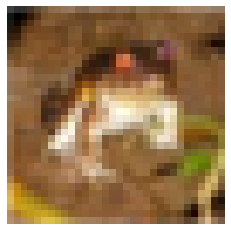

In [4]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x_train[0])
plt.axis('off')
plt.show()

Plot the first 100 image in a 10 x 10 grid to get a sense of the data, note that `for i in range(10):` will create a loop on index `i` with 10 values between 0 and 9

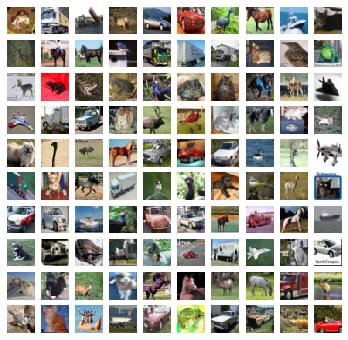

In [5]:
plt.figure(figsize=(6, 6))
for index in range(100):
    axi = plt.subplot(10, 10, index + 1)
    axi.imshow(x_train[index])
    axi.axis('off')
plt.show()

The `y_train` vector corresponds to one of the 10 class ids. observe the class ids using the `np.unique` function of `numpy`. Then look at the class index (ground thruth) of the first 5 images in the training set.

In [6]:
import numpy as np

# print all class ids
print(np.unique(y_train))

# print the class (ground truth) of the first 5 images
print(y_train[:5])

[0 1 2 3 4 5 6 7 8 9]
[[6]
 [9]
 [9]
 [4]
 [1]]


`np.where` can help locating images of a given class (use the first value returned by `where` with `[0]` to access the indices). Find the first 10 images with class 1 (car) in the train set.

In [7]:
np.where(y_train == 1)[0][:10]

array([ 4,  5, 32, 44, 45, 46, 60, 61, 64, 65])

Define a list representing the image categories: plane, car, bird, cat, deer, dog, frog, horse, boat, truck

In [8]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

Now we know how to manipulate our data, let's display the first 10 images of each class in the training set. For this we will use the same sort of code as before for plotting images on a grid, but we have to search the right indices of the images so they belong to the right class.

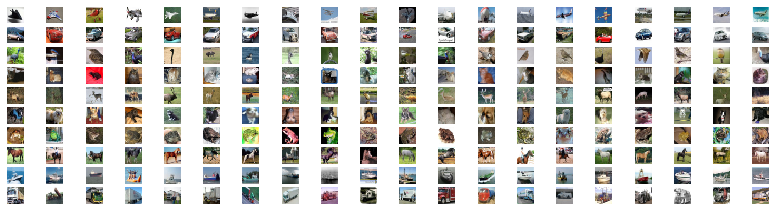

In [9]:
n = 20
plt.figure(figsize=(n*0.6, 6))
for j in range(10):
    index_class_j = np.where(y_train == j)[0][:n]
    for i in range(n):
        axi = plt.subplot(n, n, n * j + (1 + i))
        axi.imshow(x_train[index_class_j[i]])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## Model definition: distance between data points

k-Nearest-Neighbors (k-NN): the simplest machine learning algorithm (does not actually learn anything): classifies unknown data points by finding the  most common class among the $k$ closest examples ($k$ is odd).

The distance between data points need to be defined. Classical examples:

 - Manhattan distance $\sum_{i=1}^d|A_i - B_i|$
 - Euclidean distance $\sqrt{\sum_{i=1}^d(A_i - B_i)^2}$


Start by computing both Euclidean and Manhattan distances between the first two images. Be careful to cast the image data type to signed integer (use `.astype(np.int16)`)

In [10]:
A = x_train[0].astype(np.int16)
B = x_train[1].astype(np.int16)
print('data type should be int16, got: %s' % A.dtype)

d1 = np.sum(np.abs(A - B))
print('Manhattan distance: {}'.format(d1))

d2 = np.sqrt(np.sum((A - B) ** 2))
print('Euclidean distance: {}'.format(d2))

data type should be int16, got: int16
Manhattan distance: 197173
Euclidean distance: 3837.1052891470154


Now prepare for training the k-NN model.

First we reshape the data into large column vectors `X_train` and `X_test` (note the use of capital X here to distinguish them). Use the function `np.reshape` for this. A common practice here is to use a shape `(n, -1)` where n is the number of data points, eg n=50000 for x_train; using -1 will tell `reshape` to compute the size automatically here (which should be 3072). Note that both vectors must be of type signed integers (eg `np.int16`) to avoid problems with uint8 when computing L1 distance.

In [11]:
X_train = x_train.reshape((x_train.shape[0], 3072)).astype(np.int16)
X_test = x_test.reshape((x_test.shape[0], -1)).astype(np.int16)

print('shape of train data is {}, type is {}'.format(X_train.shape, X_train.dtype))
print('shape of test data is {}, type is {}'.format(X_test.shape, X_test.dtype))

shape of train data is (50000, 3072), type is int16
shape of test data is (10000, 3072), type is int16


## Run the model with k=1

Use L1 (Manhattan) distance to compare images and perform nearest neighbor prediction on a **random image of the test set**. Note that in the case of k-NN we can use image in the test set since the model is not actually learning any parameters.

Compute the L1 distance of a random image with the **first 10 images of the training set**.

In [12]:
index = np.random.randint(X_test.shape[0])
print('using image {}'.format(index))

image = X_test[index]
print(image.shape)

for i in range(10):
    d1 = np.sum(np.abs(image - X_train[i, :]))
    print(d1)

print(X_train[:10, :].shape)
d1 = np.sum(np.abs(image - X_train[:10, :]), axis=1)
print(d1)

using image 6350
(3072,)
336773
296464
287928
363788
303644
356814
286224
262795
257606
360443
(10, 3072)
[336773 296464 287928 363788 303644 356814 286224 262795 257606 360443]


Here we pick a category $c=5$ (dog). Get the first dog image in the test set and compute all $d_1$ distances (with all images in the training set). The index of the minimum distance can be obtain with function `np.argmin`. Then **make a prediction** for this image.

In [13]:
c = 5
# pick the first test image with category c
index_for_c = np.where(y_test == c)[0][0]
print('index of %s image being tested: %d' % (labels[c], index_for_c))
print(y_test[index_for_c])  # should be equal to [c]
image = X_test[index_for_c].astype(np.int16)

# compute all d1 distances
all_d1 = np.sum(np.abs(image - X_train[:, :]), axis=1)

# find the index with minimum distance
min_index = np.argmin(all_d1)
print('min_index = %d' % min_index)

# sort indices with respect to the distance
sorted_indices = np.argsort(all_d1)[:10]

# look at the predicted category
category = np.squeeze(y_train[min_index])
print('predicted class is %d' % category)
print('actual class is %d' % c)

index of dog image being tested: 12
[5]
min_index = 8398
predicted class is 5
actual class is 5


Plot the test image and the nearest neighbor image in the training set.

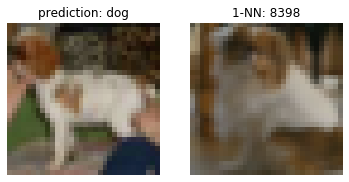

In [14]:
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index_for_c])
plt.axis('off')
plt.title('prediction: %s' % labels[category])
# now display the first NN
ax = plt.subplot(1, 2, 2)
plt.imshow(x_train[min_index])
plt.axis('off')
plt.title('1-NN: %s' % min_index)
plt.show()

Create a vertical representation of the 10 image classes using the first one of each class in the test set.

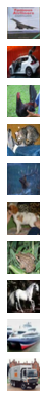

In [15]:
n = 10
plt.figure(figsize=(1, 5.8))
for c in range(n):
    index_for_c = np.where(y_test == c)[0][0]
    axi = plt.subplot(n, 1, c + 1)
    axi.imshow(x_test[index_for_c])
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

Display the first 10 nearest neighbors of each test image

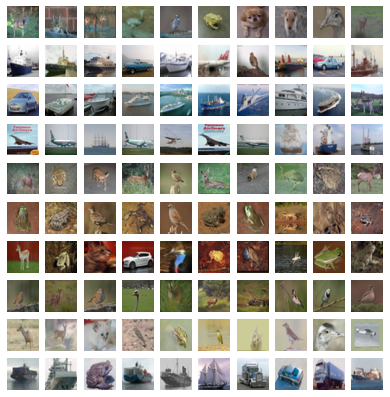

In [16]:
n = 10
plt.figure(figsize=(5.8, 5.8))
for k in range(n):
    index_for_k = k
    image = x_test[index_for_k].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:10]
    for i in range(n):
        axi = plt.subplot(n, n, n * k + (1 + i))
        axi.imshow(x_train[sorted_indices[i]])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

Create a visual representation of the pattern by averaging the first 10 NN

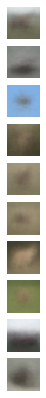

In [17]:
n = 10
plt.figure(figsize=(1, 5.8))
for c in range(n):
    index_for_c = np.where(y_test == c)[0][3]
    image = x_test[index_for_c].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:100]
    # average the NN
    pattern = np.mean(x_train[sorted_indices], axis=0).astype(np.uint8)
    axi = plt.subplot(n, 1, c + 1)
    axi.imshow(pattern)
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## Use sklearn to perform 1-NN classification

In [18]:
print('data size in memory: {:.1f} Mb'.format(X_train.nbytes / (1024 **2 )))

data size in memory: 293.0 Mb


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Create the model using the `KNeighborsClassifier` class with 1 neighbor and Manhattan distance (p=1).

In [20]:
model = KNeighborsClassifier(n_neighbors=1, p=1, algorithm='brute')

In [21]:
y_train.shape

(50000, 1)

In [22]:
model.fit(X_train, np.squeeze(y_train))

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')

Make a prediction for the first dog image in the test set.

In [23]:
image = np.reshape(X_test[12], (1, 3072))
model.predict(image)

array([5], dtype=uint8)

Get the 3 closest distances for this image.

In [24]:
distances_sklearn, indices_sklearn = model.kneighbors(image, 3)
print(distances_sklearn)
print(indices_sklearn)

[[107143. 107923. 108278.]]
[[8398 3540 4124]]


## Comparison of our 1-NN with results from sklearn model

Here we plot side by side our predictions with those obtained with the `sklearn` model.

[  993  2567 16512]
[115500 115544 116846]


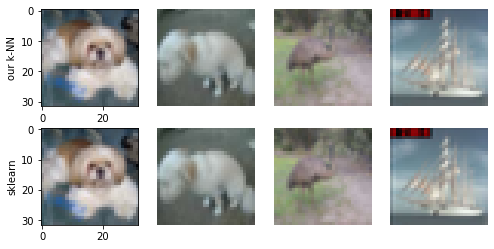

In [25]:
index = 39
image = x_test[index].astype(np.int16)
all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
sorted_indices = np.argsort(all_d1)[:3]

print(sorted_indices)
print(all_d1[sorted_indices])

plt.figure(figsize=(8, 4)) 
ax = plt.subplot(2, 4, 1)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('our k-NN')
ax = plt.subplot(2, 4, 5)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('sklearn')
for i in range(3):
    axi = plt.subplot(2, 4, (2 + i))
    axi.imshow(x_train[sorted_indices][i])
    axi.axis('off')
# compare with sklearn
indices_sklearn = [993, 2567, 16512]
distances_sklearn = [115500., 115544., 116846.]
for i in range(3):
    axi = plt.subplot(2, 4, 4 + (2 + i))
    axi.imshow(x_train[indices_sklearn][i])
    axi.axis('off')
plt.show()

## Try to change the hyper-parameters

The $k$ value and and distance metric are 2 important hyper-parameters that we can change to improve our model. Try using 3 neighbors and L2 distance (p=2).

In [26]:
model_kNN = KNeighborsClassifier(n_neighbors=3, p=2)
model_kNN.fit(X_train, np.squeeze(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

[0]


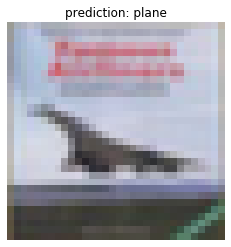

In [27]:
# test the model on a few images
k = 0
# pick the first test image with category k
index_for_k = np.where(y_test == k)[0][0]
print(y_test[index_for_k])
image = x_test[index_for_k]
category = model_kNN.predict(image.ravel().reshape((1, 3072)))[0]

plt.imshow(image)
plt.axis('off')
plt.title('prediction: %s' % labels[category])
plt.show()

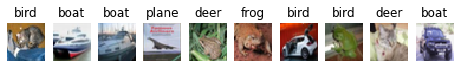

In [28]:
n = 10
predictions = model_kNN.predict(X_test[:n].reshape((n, 3072)))
plt.figure(figsize=(8, 1.5)) 
for i in range(n):
    axi = plt.subplot(1, n, (1 + i))
    axi.imshow(x_test[i])
    axi.axis('off')
    plt.title(labels[predictions[i]])
plt.show()

Warning, running the next cell takes a very long time since predictions with kNN are slow for large training sets. This is a good example of the limitation of this model.

In [29]:
print(classification_report(y_test, model_kNN.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

       plane       0.32      0.57      0.41      1000
         car       0.58      0.24      0.34      1000
        bird       0.20      0.45      0.28      1000
         cat       0.26      0.23      0.24      1000
        deer       0.25      0.44      0.32      1000
         dog       0.43      0.21      0.28      1000
        frog       0.36      0.23      0.28      1000
       horse       0.73      0.20      0.31      1000
        boat       0.44      0.61      0.51      1000
       truck       0.73      0.12      0.21      1000

    accuracy                           0.33     10000
   macro avg       0.43      0.33      0.32     10000
weighted avg       0.43      0.33      0.32     10000



Finally create an visual representation with 10 rows corresponding to 10 test images. Each row display the test image on the left and its the 10-NN images in the train set as computed by the model.

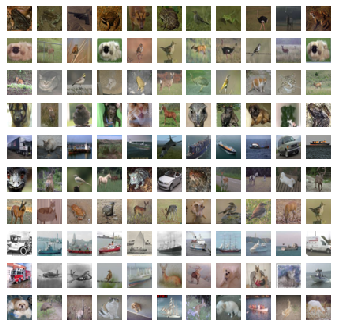

In [30]:
m = 10
offset = 30
plt.figure(figsize=(5.8, 5.8)) 
for k in range(n):
    # show the test image in the first column
    ax = plt.subplot(n, 1 + m, (m + 1) * k + 1)
    ax.imshow(x_test[offset + k])
    ax.axis('off')
    distances, indices = model_kNN.kneighbors(X_test[offset + k:offset + k + 1], m)
    for i in range(m):
        axi = plt.subplot(n, 1 + m, (m + 1) * k + (2 + i))
        axi.imshow(x_train[indices[0][i]])
        axi.axis('off')
plt.show()

One can observe the visual proximity of the image in each row. However the images are not all from the same class. We can perhaps improve the predictions by increasing $k$ but the model is simply not well adapted to so different images.